# Code to extract complex field (fourier filtering) and fluorescence, and beam propagation  (BPM)

## 1. Load libraries

In [1]:
# load libraries
import os
from multiprocessing import Pool
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import find_peaks
from scipy.ndimage import laplace #, gaussian_filter

from skimage.restoration import unwrap_phase
from skimage.feature import match_template

import h5py

from skimage import filters

#from scipy.ndimage import gaussian_filter
import imageio.v3 as iio

import time
from scipy import special
import pathlib

import math
import cmath

## 2. Load and display data

In [2]:
import os
import numpy as np
from PIL import Image
from multiprocessing import Pool

# --- config ---
base_directory = '/home/jvasquez/updepla/users/jvasquez/DATA_raw_QPI/20250929_BJ_ctrl'
image_prefix   = '20250929_BJ_ctrl_'
sigma_cell_pixel_size = 180

start_image_number = 201
end_image_number   = 704

# Optional nearest-background search window:
# 0 -> do NOT look back (default). N -> look back image_number-1 .. image_number-N
looking_back_no_indices = 0

# Manual toggle for backup background (default OFF)
USE_BACKUP_BACKGROUND = False
backup_background_image_number = 102   # used only if USE_BACKUP_BACKGROUND=True

# Progress fallback print cadence (only used if tqdm isn't installed)
PROGRESS_EVERY = 10

# Try tqdm for a live progress bar
try:
    from tqdm import tqdm
    _USE_TQDM = True
except Exception:
    _USE_TQDM = False

# --- function ---
def load_image(image_number):
    image_of_interest = f"{image_prefix}{image_number}"
    hologram_image_file_path     = os.path.join(base_directory, f"{image_of_interest}_HOLO.tif")
    fluorescence_image_file_path = os.path.join(base_directory, f"{image_of_interest}_FLUOR.tif")

    # 0) first try same-index background
    background_image_file_path = os.path.join(base_directory, f"{image_prefix}{image_number}_HOLO_EMPTY.tif")
    if not os.path.exists(background_image_file_path):
        background_image_file_path = None

    # 1) optional: look back up to N prior indices
    if background_image_file_path is None and looking_back_no_indices > 0:
        for i in range(1, looking_back_no_indices + 1):
            candidate_num = image_number - i
            if candidate_num < 1:
                break
            possible_bg = os.path.join(base_directory, f"{image_prefix}{candidate_num}_HOLO_EMPTY.tif")
            if os.path.exists(possible_bg):
                background_image_file_path = possible_bg
                break

    # 2) optional fallback background (OFF by default)
    if background_image_file_path is None:
        if USE_BACKUP_BACKGROUND:
            backup_image_file = f"{image_prefix}{backup_background_image_number}_HOLO_EMPTY.tif"
            backup_path = os.path.join(base_directory, backup_image_file)
            if os.path.exists(backup_path):
                background_image_file_path = backup_path
            else:
                return None  # skip
        else:
            return None  # skip

    # 3) load images
    try:
        hologram_image   = np.array(Image.open(hologram_image_file_path))
        background_image = np.array(Image.open(background_image_file_path))
        try:
            fluorescence_image = np.array(Image.open(fluorescence_image_file_path))
        except FileNotFoundError:
            fluorescence_image = np.zeros_like(hologram_image)
            missing_fluorescence_list.append(image_of_interest)
    except FileNotFoundError:
        return None  # skip

    return {
        'image_of_interest': image_of_interest,
        'hologram_image': hologram_image,
        'background_image': background_image,
        'fluorescence_image': fluorescence_image
    }

# --- run with live progress ---
missing_fluorescence_list = []
total = end_image_number - start_image_number + 1
results = []

with Pool() as pool:
    iterator = pool.imap_unordered(load_image, range(start_image_number, end_image_number + 1))
    if _USE_TQDM:
        # tqdm progress bar (fast & simple)
        for r in tqdm(iterator, total=total, desc="Loading images"):
            results.append(r)
    else:
        # Fallback: periodic console prints
        done = 0
        for r in iterator:
            results.append(r)
            done += 1
            if done % PROGRESS_EVERY == 0 or done == total:
                print(f"[PROGRESS] {done}/{total} ({done/total:.1%})")

# keep only successful loads
image_data = [x for x in results if x is not None]


Loading images: 100%|██████████| 504/504 [00:19<00:00, 26.50it/s]


In [3]:
image_data

[{'image_of_interest': '20250929_BJ_ctrl_203',
  'hologram_image': array([[ 901,  891,  766, ..., 1586, 1200, 1258],
         [ 960,  918,  911, ..., 1460, 1280, 1730],
         [ 929,  960, 1037, ..., 1282, 1740, 1957],
         ...,
         [ 686,  893, 1226, ...,  803,  847,  989],
         [ 763,  971,  991, ...,  816,  958, 1001],
         [ 859,  791,  595, ...,  941,  959,  897]], dtype=uint16),
  'background_image': array([[ 834,  748,  715, ..., 1539, 1166, 1381],
         [ 862,  829,  815, ..., 1345, 1482, 1908],
         [ 852,  861,  967, ..., 1429, 2014, 1950],
         ...,
         [ 816,  831, 1168, ...,  845,  883,  954],
         [ 683,  974, 1129, ...,  848,  933, 1054],
         [ 774,  891,  704, ...,  910,  944,  957]], dtype=uint16),
  'fluorescence_image': array([[53, 61, 48, ..., 46, 45, 47],
         [60, 60, 54, ..., 47, 50, 52],
         [56, 59, 56, ..., 45, 49, 52],
         ...,
         [61, 55, 52, ..., 51, 53, 51],
         [58, 63, 57, ..., 48, 54, 

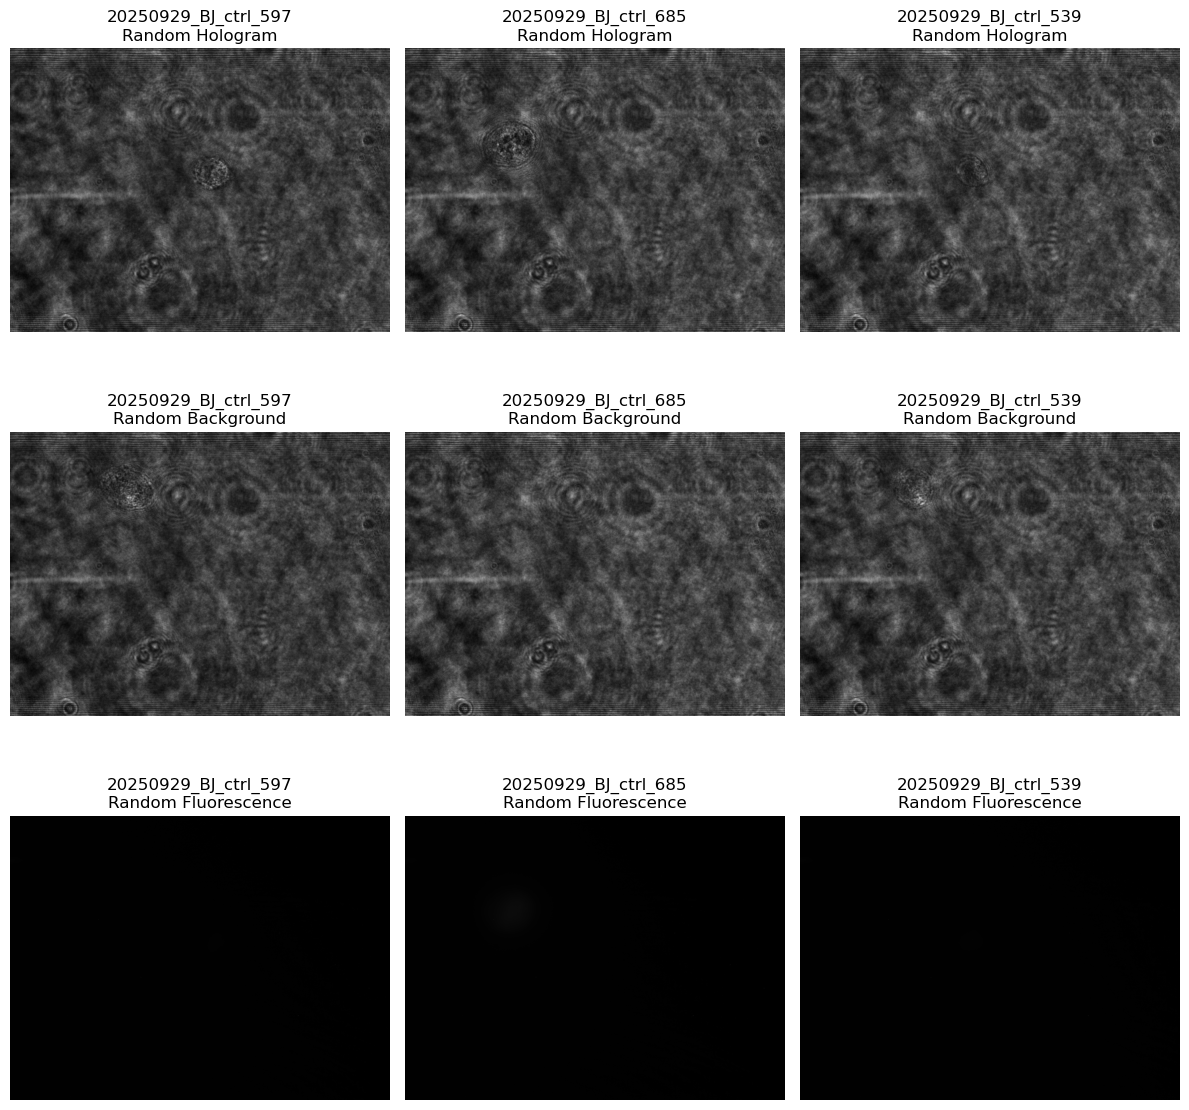

In [5]:
# Set figure DPI
fig_dpi = 100

# Function to plot images
def plot_images(images, titles):
    num_images = len(images)
    rows = int(np.ceil(num_images / 3))  # Adjust the number of columns here
    cols = min(num_images, 3)
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4), dpi=fig_dpi)
    axes = axes.flatten()

    for i, (image, title) in enumerate(zip(images, titles)):
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(title)
        axes[i].axis('off')

    for i in range(num_images, rows*cols):
        fig.delaxes(axes[i])  # Remove unused subplots

    plt.tight_layout()
    plt.show()

# Generate random indices within the range of available images
num_images_available = len(image_data)
num_random_indices = 3  # You can adjust this based on how many random indices you need

# Set a seed for reproducibility
#random.seed(42)  # You can use any integer value as the seed

# Generate unique random indices within the range of available images
random_indices = random.sample(range(num_images_available), num_random_indices)

# Extract images using random indices
images = [
    image_data[idx]['hologram_image'] for idx in random_indices
] + [
    image_data[idx]['background_image'] for idx in random_indices
] + [
    image_data[idx]['fluorescence_image'] for idx in random_indices
]

# Extract image of interest names
image_of_interest_names = [image_data[idx]['image_of_interest'] for idx in random_indices]

# Construct titles including image of interest names
titles = [f'{name}\nRandom Hologram' for name in image_of_interest_names]
titles.extend([f'{name}\nRandom Background' for name in image_of_interest_names])
titles.extend([f'{name}\nRandom Fluorescence' for name in image_of_interest_names])

# Plot images
plot_images(images, titles)


## 3. Complex field

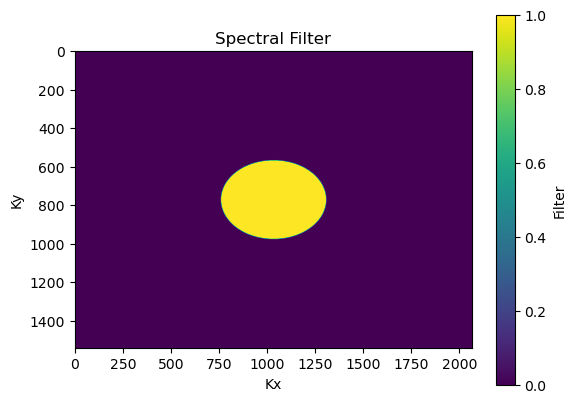

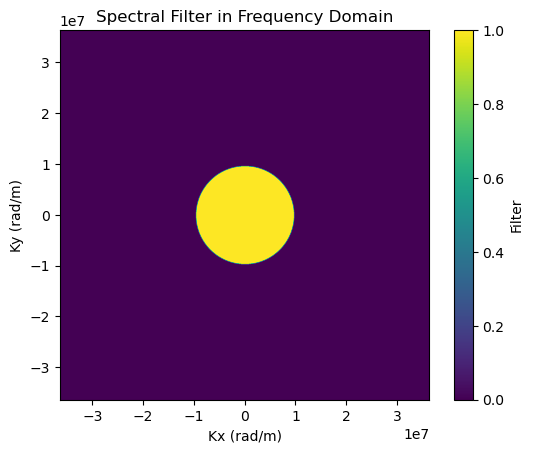

In [6]:
# Input parameters
n0 = 1.33  # Refractive index of background
lambda0 = 488e-9  # Free space wavelength [m]
na_system = 0.75  # Numerical aperture of the system
#na_system = 0.1  # Numerical aperture of the system
camera_pixel_size = 3.45e-6  # Camera pixel size [m]
magnification = 40  # Magnification
dx = camera_pixel_size / magnification  # Discretization step in x

# Free space wavenumber [m-1]
k0 = 2 * np.pi / lambda0

# Effective numerical aperture
effective_NA = min(na_system, n0)

# Size of computational grid
Nx_cam = image_data[0]['hologram_image'].shape[1]  # Columns (x-direction)
Ny_cam = image_data[0]['hologram_image'].shape[0]  # Rows (y-direction)

dy = dx  # Discretization step in y

# Physical dimensions of the computation space
Nx = Nx_cam  # x-direction size of computational grid
Ny = Ny_cam  # y-direction size of computational grid

# Numeric model parameters
x = np.arange(-Nx / 2, Nx / 2) * dx  # Normalized x dimension vector
y = np.arange(-Ny / 2, Ny / 2) * dy  # Normalized y dimension vector

dkx = 2 * np.pi / (Nx * dx)  # Discretization in the spatial spectral domain along the x direction
dky = 2 * np.pi / (Ny * dy)  # Discretization in the spatial spectral domain along the y direction

kx = np.arange(-Nx / 2, Nx / 2) * dkx  # Spatial frequencies vector in the x direction
ky = np.arange(-Ny / 2, Ny / 2) * dky  # Spatial frequencies vector in the y direction

# Spatial computation grid of physical domain
X, Y = np.meshgrid(x, y)

# Spatial computation grid of frequency domain
Kx, Ky = np.meshgrid(kx, ky)

# Magnitude of spatial frequency vector squared
K2 = Kx ** 2 + Ky ** 2

# Define the spectral filter in the frequency domain
spectral_filterFF = K2 < (k0 * effective_NA) ** 2

# Plot the spectral filter
plt.figure()
plt.imshow(spectral_filterFF)
plt.title('Spectral Filter')
plt.xlabel('Kx')
plt.ylabel('Ky')
plt.colorbar(label='Filter')
plt.show()

# Plot the spectral filter
plt.figure()
plt.imshow(spectral_filterFF, extent=(kx.min(), kx.max(), ky.min(), ky.max()))
plt.title('Spectral Filter in Frequency Domain')
plt.xlabel('Kx (rad/m)')
plt.ylabel('Ky (rad/m)')
plt.colorbar(label='Filter')
plt.show()

## Function for complex field extraction

In [7]:
def complex_field_extraction(hologram_input, first_order_peak_input=1, peak_threshold_input=0.9, plot=False):
    """
    Extracts the complex field from a hologram.

    Parameters:
        hologram_input (numpy.ndarray): Input hologram.
        first_order_peak_input (int, optional): Input for selecting the first-order peak (1 or 2). Default is 1.
        peak_threshold_input (float, optional): Threshold for peak detection. Default is 0.9.
        plot (bool, optional): Whether to plot the results. Default is False.

    Returns:
        numpy.ndarray: Complex field extracted from the hologram.
    """
    
    # Your existing code here...
    
    # Complex field extraction
    Ir = hologram_input
    Ir_spec = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(Ir)))
    
    # Peak detection

    # Exclude the DC component from peak finding
    center_x, center_y = np.array(Ir_spec.shape) // 2
    radius = int(np.sqrt(np.sum(spectral_filterFF)) // np.pi)*2 #use a factor of 2 to increase the radius of the area ignored
    Ir_spec_no_dc = Ir_spec.copy()
    Ir_spec_no_dc[center_x - radius:center_x + radius, center_y - radius:center_y + radius] = 0

    # Plotting if requested
    if plot:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(np.log(np.abs(Ir_spec) + 1e-10), cmap='gray')  # Add a small value to avoid log(0)
        plt.title('Magnitude with DC Component')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.colorbar(label='Magnitude')
        
        plt.figure()
        plt.imshow(np.log(np.abs(Ir_spec) + 1e-10), extent=(kx.min(), kx.max(), ky.min(), ky.max())) # with fixed apect ratio
        plt.colorbar(label='Magnitude')
        plt.title('Frequency space')
        plt.xlabel('X (rad/m)')
        plt.ylabel('Y (rad/m)')
        plt.show()

    # Automatic detection of first-order peaks (excluding DC)
    peak_threshold = peak_threshold_input
    peaks, _ = find_peaks(np.abs(Ir_spec_no_dc).ravel(), height=np.max(np.abs(Ir_spec_no_dc)) * peak_threshold, distance=100)

    # Convert peak indices to coordinates
    peak_indices_y, peak_indices_x = np.unravel_index(peaks, Ir_spec_no_dc.shape)

    # Find the two strongest peaks that are farthest apart
    max_distance = 0
    best_peak_pair = None

    for i in range(len(peak_indices_x)):
        for j in range(i + 1, len(peak_indices_x)):
            distance = np.sqrt((peak_indices_x[i] - peak_indices_x[j]) ** 2 + (peak_indices_y[i] - peak_indices_y[j]) ** 2)
            if distance > max_distance:
                max_distance = distance
                best_peak_pair = (i, j)

    # Plotting if requested
    if plot:
        plt.subplot(1, 3, 2)
        plt.imshow(np.log(np.abs(Ir_spec_no_dc) + 1e-10), cmap='gray')  # Add a small value to avoid log(0)
        plt.title('Magnitude with Detected Peaks (No DC)')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.colorbar(label='Magnitude')
        plt.plot(peak_indices_x, peak_indices_y, 'ro', markersize=5, label='Peaks')
        plt.legend()

    # Plotting if requested
    if plot:
        plt.subplot(1, 3, 3)
        if best_peak_pair is not None:
            peak_x = [peak_indices_x[best_peak_pair[0]], peak_indices_x[best_peak_pair[1]]]
            peak_y = [peak_indices_y[best_peak_pair[0]], peak_indices_y[best_peak_pair[1]]]
            plt.imshow(np.log(np.abs(Ir_spec_no_dc) + 1e-10), cmap='gray')  # Add a small value to avoid log(0)
            plt.plot(peak_x, peak_y, 'ro', markersize=10, label='Farthest Apart', markerfacecolor='none', markeredgewidth=2)
        plt.title('Magnitude with 2 Farthest Apart Peaks (No DC)')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.colorbar(label='Magnitude')
        plt.legend()

        plt.tight_layout()
        plt.show()

    # Choose and isolate the first-order peak
    first_order_peak = first_order_peak_input

    if first_order_peak == '':
        first_order_peak = 1
    else:
        first_order_peak = int(first_order_peak)
        
    print(f"Available peaks: {len(peak_indices_x)}")
    print(f"Best peak pair: {best_peak_pair}")

    if first_order_peak == 1:
        peak_location = (peak_indices_x[best_peak_pair[0]], peak_indices_y[best_peak_pair[0]])
    elif first_order_peak == 2:
        peak_location = (peak_indices_x[best_peak_pair[1]], peak_indices_y[best_peak_pair[1]])
    else:
        print("Invalid input. Please enter 1 or 2.")

    # Use the radius of spectral_filterFF as the mask to isolate the first order
    radius = int(np.sqrt(np.sum(spectral_filterFF)) // np.pi) * 2  # Increase radius factor

    # Calculate the coordinates for the bounding box around the peak
    xm = np.floor(peak_location[0])
    ym = np.floor(peak_location[1])
    dxm = radius
    dym = radius

    Ir_spec_clean = np.zeros_like(Ir_spec)

    # Set the segmented region to the corresponding part of Ir_spec
    Ir_spec_clean[int(ym - dym):int(ym + dym), int(xm - dxm):int(xm + dxm)] = Ir_spec[int(ym - dym):int(ym + dym), int(xm - dxm):int(xm + dxm)]

    # Plotting if requested
    if plot:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(np.log(np.abs(Ir_spec_clean)+ 1e-10), cmap='gray')
        plt.title('Magnitude of Isolated First-Order Peak')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.colorbar(label='Magnitude')
        plt.show()

    # Find the index of the maximum value in Ir_spec_clean
    max_idx_flat = np.argmax(np.abs(Ir_spec_clean))

    # Convert the flattened index to row and column indices
    max_y, max_x = np.unravel_index(max_idx_flat, Ir_spec_clean.shape)

    # Calculate reference_pixel_shift_x and reference_pixel_shift_y
    reference_pixel_shift_x = max_x - round((Nx + 1) / 2)
    reference_pixel_shift_y = max_y - round((Ny + 1) / 2)

    # frame
    frame = Ir

    # Normalize the frame
    power = np.sum(np.abs(frame)) / (Nx_cam * Ny_cam)
    Ir = frame / power

    # Compute the Fourier transform of the normalized frame
    Ir_spec = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(Ir)))

     # Shift the 1st diffraction order to the center of Fourier space
    Ir_spec_shifted = np.roll(Ir_spec, (-int(reference_pixel_shift_y), -int(reference_pixel_shift_x)), axis=(0, 1))

    # Filter out just the centered 1st order
    Ir_spec_filtered = Ir_spec_shifted * spectral_filterFF
    
    if plot:
        plt.figure()
        plt.imshow(np.log(np.abs(Ir_spec_filtered)+ 1e-10), cmap='gray')
        plt.colorbar(label='Magnitude')
        plt.title('Filtered Fourier Transform EXTENDED')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()
        
        plt.figure()
        plt.imshow(np.log(np.abs(Ir_spec_filtered)+ 1e-1), extent=(kx.min(), kx.max(), ky.min(), ky.max())) # with fixed apect ratio
        plt.colorbar(label='Magnitude')
        plt.title('Filtered Fourier Transform')
        plt.xlabel('X (rad/m)')
        plt.ylabel('Y (rad/m)')
        plt.show()

    # Compute the inverse Fourier transform to obtain the background incidence field
    UI = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(Ir_spec_filtered)))

    if plot:
        plt.figure()
        plt.imshow(np.abs(UI), cmap='gray')
        plt.colorbar(label='Magnitude')
        plt.title('Magnitude of Background Incidence Field')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()

        plt.figure()
        plt.imshow(np.angle(UI), cmap='gray')
        plt.colorbar(label='Phase')
        plt.title('Phase of Background Incidence Field')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()

    return UI

## Process the code

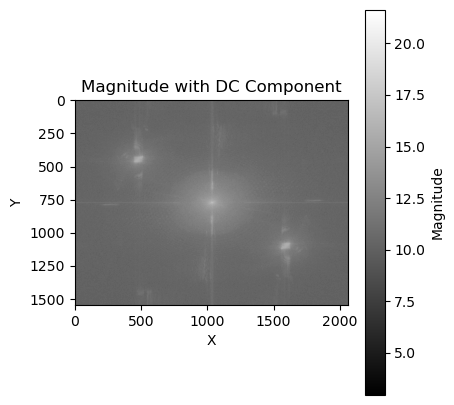

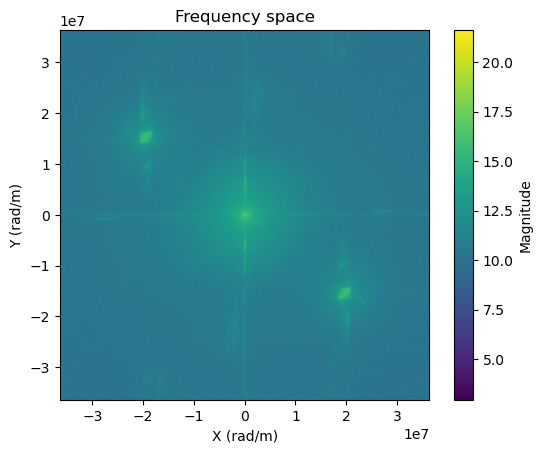

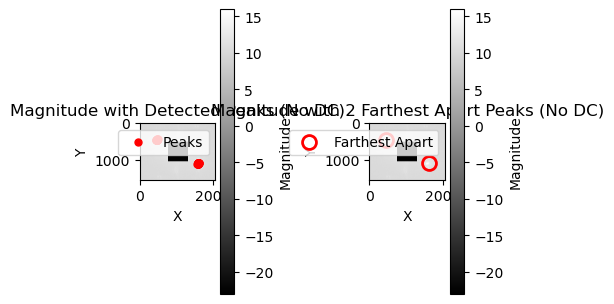

Available peaks: 36
Best peak pair: (16, 19)


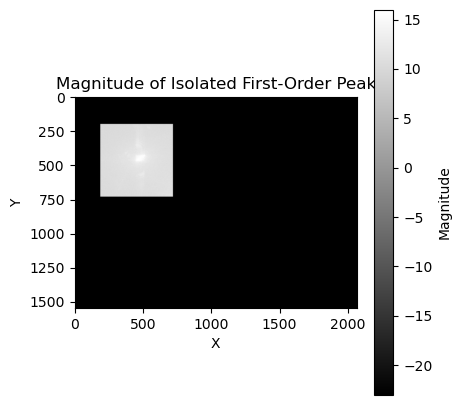

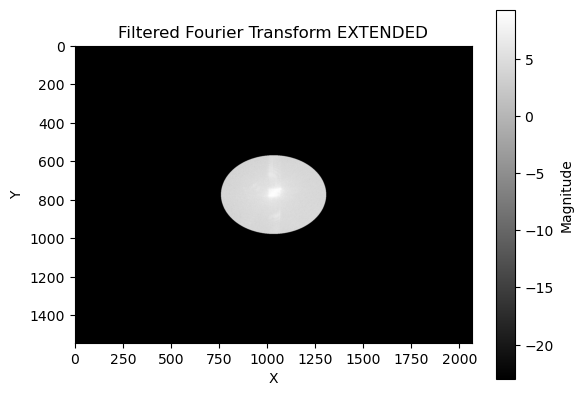

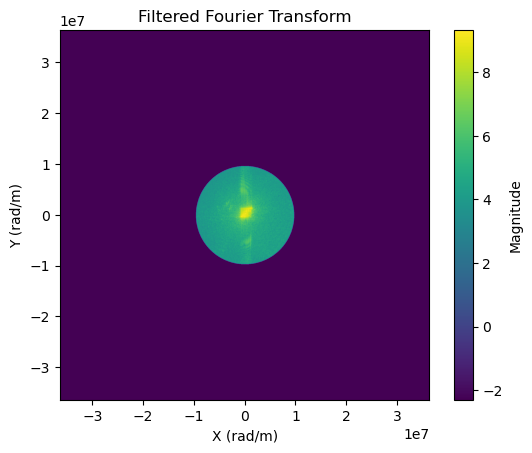

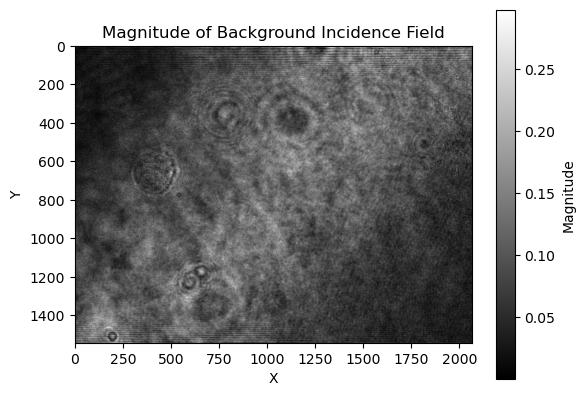

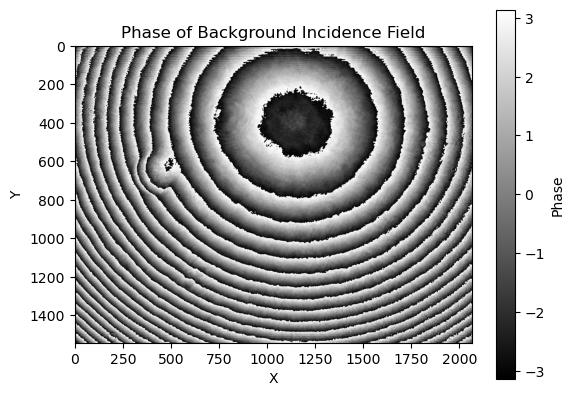

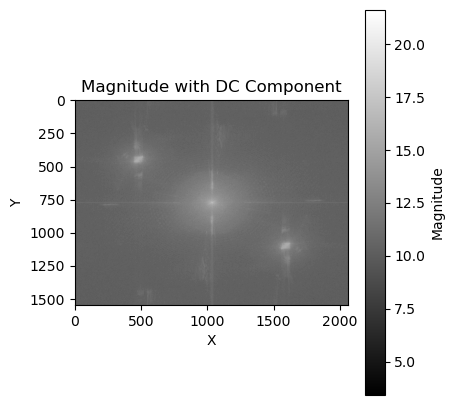

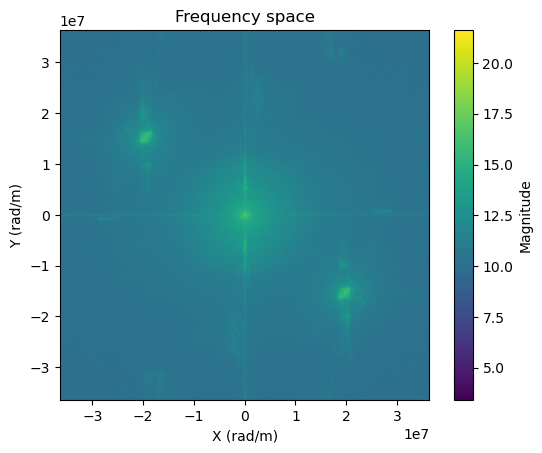

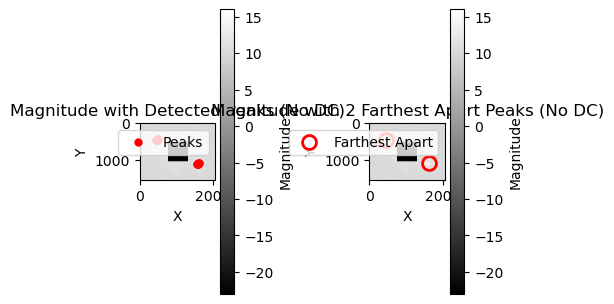

Available peaks: 16
Best peak pair: (6, 9)


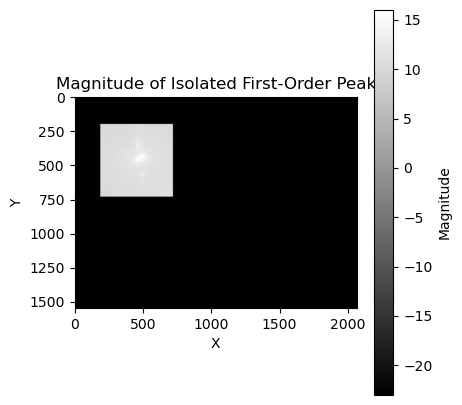

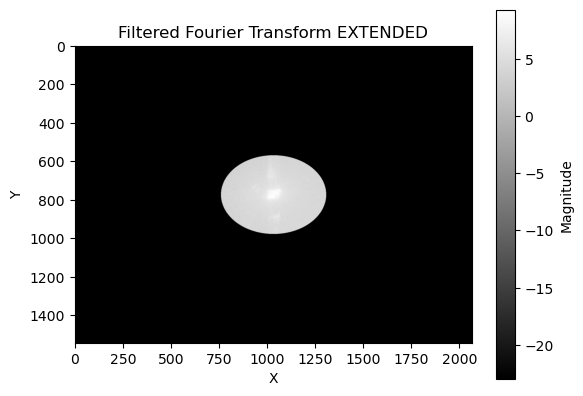

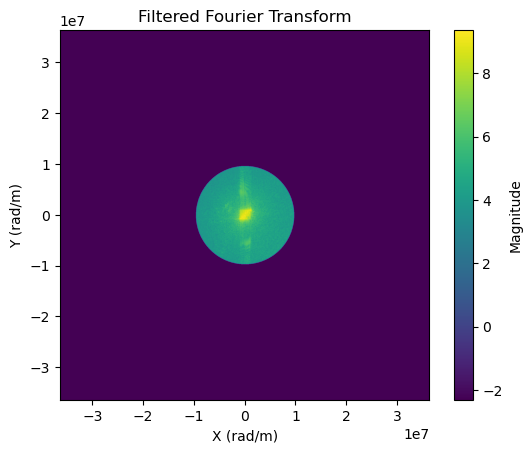

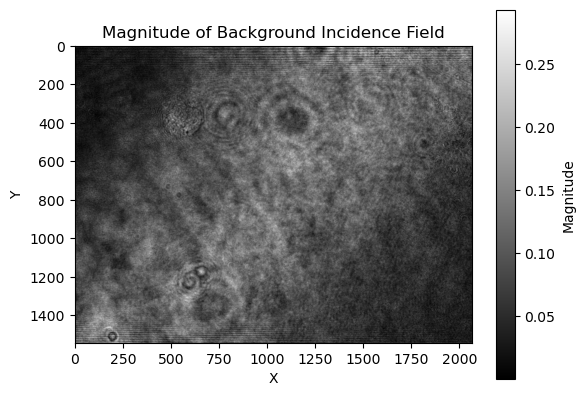

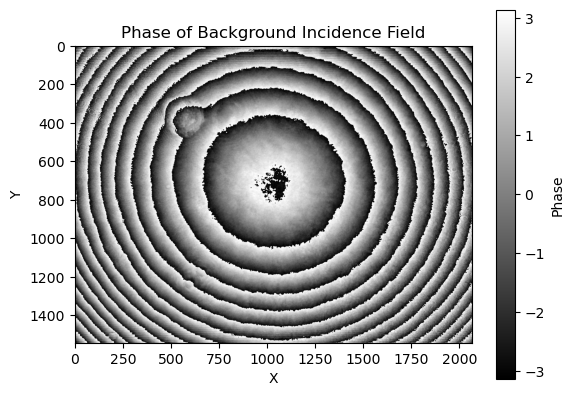

Available peaks: 22
Best peak pair: (9, 12)
Available peaks: 8
Best peak pair: (3, 4)
Available peaks: 30
Best peak pair: (13, 16)
Available peaks: 26
Best peak pair: (11, 14)
Available peaks: 42
Best peak pair: (18, 23)
Available peaks: 24
Best peak pair: (10, 13)
Available peaks: 22
Best peak pair: (9, 12)
Available peaks: 12
Best peak pair: (4, 7)
Available peaks: 26
Best peak pair: (11, 14)
Available peaks: 18
Best peak pair: (7, 10)
Available peaks: 30
Best peak pair: (12, 17)
Available peaks: 38
Best peak pair: (16, 21)
Available peaks: 20
Best peak pair: (8, 11)
Available peaks: 24
Best peak pair: (9, 14)
Available peaks: 22
Best peak pair: (6, 15)
Available peaks: 24
Best peak pair: (10, 13)
Available peaks: 36
Best peak pair: (16, 19)
Available peaks: 4
Best peak pair: (0, 3)
Available peaks: 38
Best peak pair: (17, 20)
Available peaks: 22
Best peak pair: (9, 12)
Available peaks: 24
Best peak pair: (10, 13)
Available peaks: 32
Best peak pair: (14, 17)
Available peaks: 20
Best 

In [8]:
# Loop through image data to process cell and background images
for idx, data in enumerate(image_data):
        # Process the cell image
    u_cell = complex_field_extraction(data['hologram_image'], plot=(idx == 0),peak_threshold_input=0.90)
    data['u_cell'] = u_cell
    
        # Process the background image
    u_background = complex_field_extraction(data['background_image'], plot=(idx == 0), peak_threshold_input=0.90) #, plot=(idx == 0))
    data['u_background'] = u_background
    

In [9]:
idx, data

(501,
 {'image_of_interest': '20250929_BJ_ctrl_701',
  'hologram_image': array([[ 711,  709,  706, ...,  385,  350,  409],
         [ 641,  633,  633, ...,  316,  350,  468],
         [ 606,  617,  574, ...,  317,  422,  373],
         ...,
         [ 993, 1225,  955, ...,  328,  321,  357],
         [1208, 1006,  729, ...,  392,  359,  409],
         [1057,  723,  826, ...,  393,  388,  426]], dtype=uint16),
  'background_image': array([[ 736,  701,  698, ...,  656,  481,  485],
         [ 645,  636,  628, ...,  620,  530,  769],
         [ 557,  550,  566, ...,  583,  771,  957],
         ...,
         [ 832, 1066,  862, ...,  796,  743,  714],
         [1060,  937,  683, ...,  800,  787,  801],
         [1024,  751,  772, ...,  810,  820,  930]], dtype=uint16),
  'fluorescence_image': array([[54, 59, 56, ..., 45, 49, 45],
         [54, 57, 59, ..., 46, 49, 50],
         [59, 52, 57, ..., 51, 49, 51],
         ...,
         [54, 56, 58, ..., 69, 68, 78],
         [60, 56, 54, ..., 64

## Extract amplitude and phase

In [10]:
def extract_amplitude_and_phase(u_cell, u_background):
    """
    Extracts amplitude and phase from complex fields.

    Parameters:
        u_cell (numpy.ndarray): Complex field of the cell.
        u_background (numpy.ndarray): Complex background field.

    Returns:
        numpy.ndarray: Amplitude.
        numpy.ndarray: Phase.
        numpy.ndarray: Phase with added constant.
    """
    # Calculate amplitude
    amplitude = np.abs(u_cell) ** 2
    
    # Calculate phase
    phase = np.imag(np.log(u_cell/u_background))
    phase_expj1d66 = np.angle(u_cell / u_background * np.exp(1j * 1.66))
          
    return amplitude, phase, phase_expj1d66


In [11]:
# Loop through image data to extract amplitude and phase for each image
for data in image_data:
    # Extract complex fields for the current image
    u_cell = data['u_cell']
    u_background = data['u_background']
    
    # Extract amplitude and phase using the complex fields
    amplitude, phase, phase_expj1d66 = extract_amplitude_and_phase(u_cell, u_background)
    
    # Store the results in the image data dictionary
    data['amplitude'] = amplitude
    data['phase'] = phase
    data['phase_expj1d66'] = phase_expj1d66

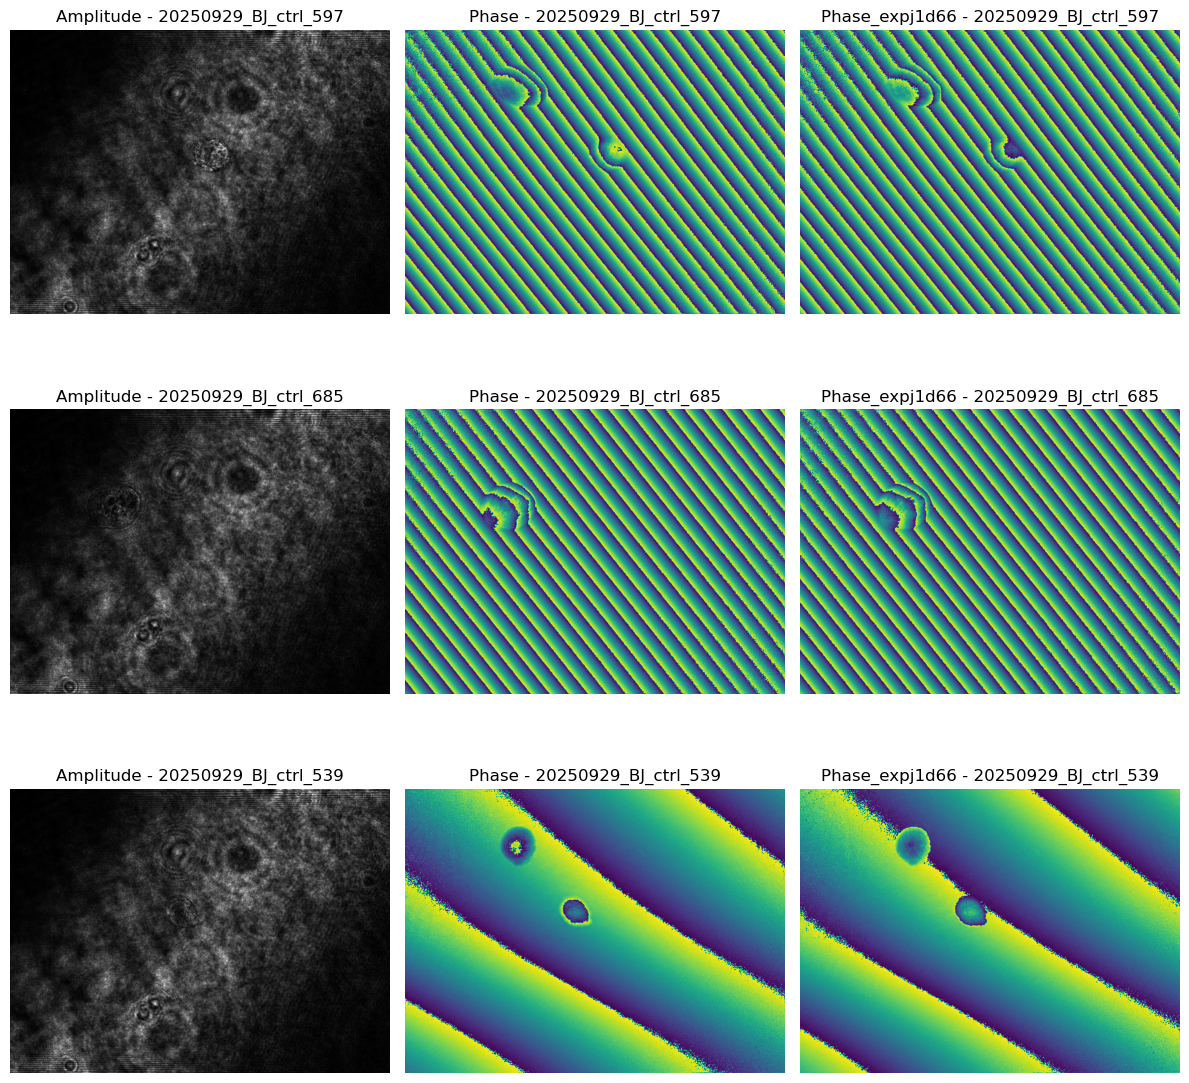

In [12]:
# Function to plot amplitude, phase, and phase_expj1d66 of fluorescence images
def plot_amplitude_and_phase(image_data, random_indices):
    num_images = len(random_indices)
    fig, axes = plt.subplots(num_images, 3, figsize=(12, num_images * 4), dpi=fig_dpi)

    for i, idx in enumerate(random_indices):
        try:
            # Extract complex fields for the current image
            u_cell = image_data[idx]['u_cell']
            u_background = image_data[idx]['u_background']

            # Extract amplitude, phase, and phase_expj1d66 using the complex fields
            amplitude, phase, phase_expj1d66 = extract_amplitude_and_phase(u_cell, u_background)

            # Plot amplitude
            axes[i, 0].imshow(amplitude, cmap='gray')
            axes[i, 0].set_title(f'Amplitude - {image_data[idx]["image_of_interest"]}')
            axes[i, 0].axis('off')

            # Plot phase
            axes[i, 1].imshow(phase, cmap='viridis')
            axes[i, 1].set_title(f'Phase - {image_data[idx]["image_of_interest"]}')
            axes[i, 1].axis('off')
            
            # Plot phase_expj1d66
            axes[i, 2].imshow(phase_expj1d66, cmap='viridis')
            axes[i, 2].set_title(f'Phase_expj1d66 - {image_data[idx]["image_of_interest"]}')
            axes[i, 2].axis('off')
            
        except KeyError:
            print(f"Complex fields not found for image {image_data[idx]['image_of_interest']}. Skipping...")

    plt.tight_layout()
    plt.show()

# Plot amplitude, phase, and phase_expj1d66 for the randomly selected images
plot_amplitude_and_phase(image_data, random_indices)

## Phase unwrapping

In [13]:
# Function to unwrap phase and store it in image_data dictionary
def unwrap_and_store_phase(image_data):
    for data in image_data:
        try:
            # Unwrap the phase
            unwrapped_phase = unwrap_phase(data['phase'])

            # Store the unwrapped phase in the image_data dictionary
            data['unwrapped_phase'] = unwrapped_phase
        except KeyError:
            print(f"Phase data not found for image {data['image_of_interest']}. Skipping...")

In [14]:
# Call the function to unwrap phase and store it in image_data dictionary
unwrap_and_store_phase(image_data)

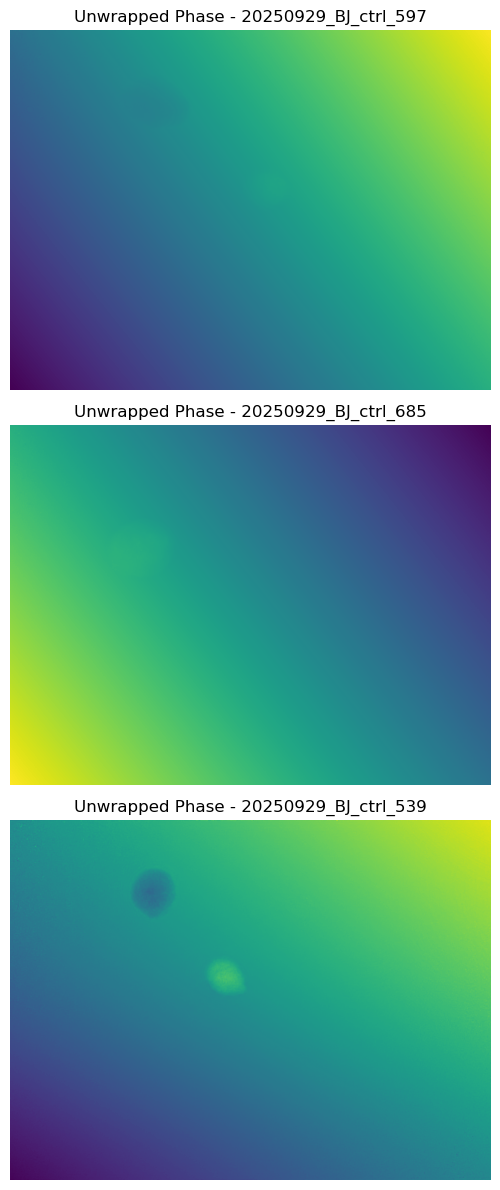

In [15]:
# Function to plot unwrapped phase for randomly selected images
def plot_unwrapped_phase(image_data, random_indices):
    num_images = len(random_indices)
    fig, axes = plt.subplots(num_images, figsize=(6, num_images * 4), dpi=fig_dpi)

    for i, idx in enumerate(random_indices):
        try:
            # Extract unwrapped phase for the current image
            unwrapped_phase = image_data[idx]['unwrapped_phase']

            # Plot unwrapped phase
            axes[i].imshow(unwrapped_phase, cmap='viridis')
            axes[i].set_title(f'Unwrapped Phase - {image_data[idx]["image_of_interest"]}')
            axes[i].axis('off')

        except KeyError:
            print(f"Unwrapped phase data not found for image {image_data[idx]['image_of_interest']}. Skipping...")

    plt.tight_layout()
    plt.show()

# Plot unwrapped phase for the randomly selected images
plot_unwrapped_phase(image_data, random_indices)


## Background substraction

In [16]:
# Function to substract the gaussian filtered image
#def background_subs_gaussian (image_data, sigma_input = 180):
def background_subs_gaussian (image_data, sigma_input = sigma_cell_pixel_size): #change according to bead size
    for data in image_data:
        try:
            # Unwrap the phase
            filtered_phase_image = filters.gaussian(data['unwrapped_phase'], sigma=sigma_input)
            #filtered_phase_image = gaussian_filter(unwrapped_phase, sigma=sigma_input) #in theory it's supposed to be faster
            back_subs_phase_image = data['unwrapped_phase'] - filtered_phase_image
            back_subs_unwrapped_phase = back_subs_phase_image 

            # Store the unwrapped phase in the image_data dictionary
            data['back_subs_unwrapped_phase'] = back_subs_unwrapped_phase
        except KeyError:
            print(f"Phase data not found for image {data['image_of_interest']}. Skipping...")


In [17]:
"""
# Try new "faster" gaussian filter

def background_subs_gaussian(image_data, sigma_input=sigma_cell_pixel_size):
    for data in image_data:
        try:
            # Apply Gaussian filter to the unwrapped phase image
            filtered_phase_image = gaussian_filter(data['unwrapped_phase'], sigma=sigma_input)
            
            # Subtract the filtered image from the original unwrapped phase
            back_subs_phase_image = data['unwrapped_phase'] - filtered_phase_image
            
            # Store the background-subtracted unwrapped phase in the image_data dictionary
            data['back_subs_unwrapped_phase'] = back_subs_phase_image
        except KeyError:
            print(f"Phase data not found for image {data['image_of_interest']}. Skipping...")
            
"""


'\n# Try new "faster" gaussian filter\n\ndef background_subs_gaussian(image_data, sigma_input=sigma_cell_pixel_size):\n    for data in image_data:\n        try:\n            # Apply Gaussian filter to the unwrapped phase image\n            filtered_phase_image = gaussian_filter(data[\'unwrapped_phase\'], sigma=sigma_input)\n            \n            # Subtract the filtered image from the original unwrapped phase\n            back_subs_phase_image = data[\'unwrapped_phase\'] - filtered_phase_image\n            \n            # Store the background-subtracted unwrapped phase in the image_data dictionary\n            data[\'back_subs_unwrapped_phase\'] = back_subs_phase_image\n        except KeyError:\n            print(f"Phase data not found for image {data[\'image_of_interest\']}. Skipping...")\n            \n'

In [18]:
# implement the background substraction
background_subs_gaussian(image_data)

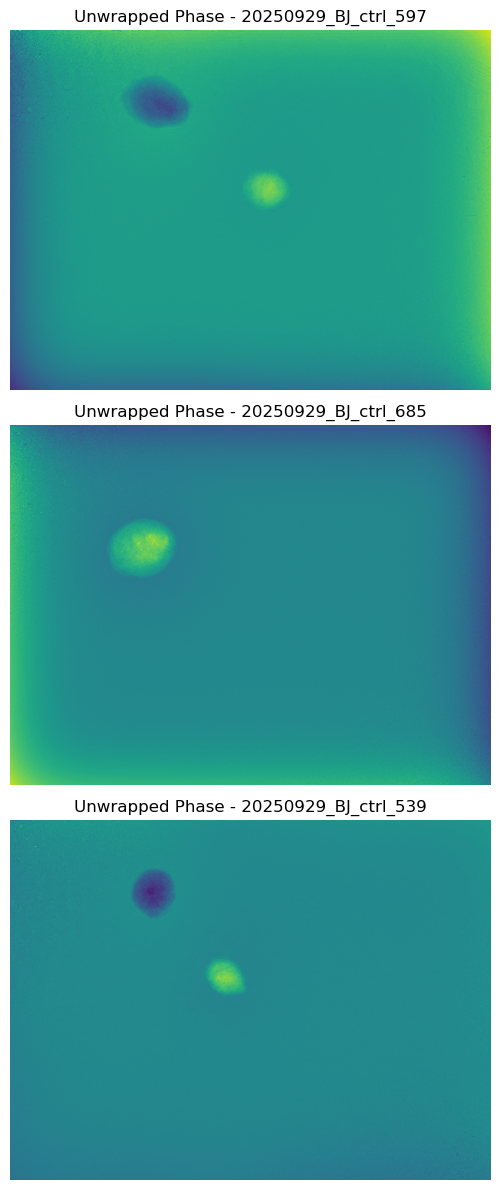

In [19]:
# Function to plot unwrapped phase for randomly selected images
def plot_background_subs(image_data, random_indices):
    num_images = len(random_indices)
    fig, axes = plt.subplots(num_images, figsize=(6, num_images * 4), dpi=fig_dpi)

    for i, idx in enumerate(random_indices):
        try:
            # Extract unwrapped phase for the current image
            unwrapped_phase = image_data[idx]['back_subs_unwrapped_phase']

            # Plot unwrapped phase
            axes[i].imshow(unwrapped_phase, cmap='viridis')
            axes[i].set_title(f'Unwrapped Phase - {image_data[idx]["image_of_interest"]}')
            axes[i].axis('off')

        except KeyError:
            print(f"Unwrapped phase data not found for image {image_data[idx]['image_of_interest']}. Skipping...")

    plt.tight_layout()
    plt.show()

# Plot unwrapped phase for the randomly selected images
plot_background_subs(image_data, random_indices)

## Find the cell

In [20]:
def find_cell(unwrapped_phase):
    #template matching method
    # Define a circular template
    template_radius = 180 // 2
    y, x = np.ogrid[-template_radius:template_radius, -template_radius:template_radius]
    mask = x**2 + y**2 <= template_radius**2
    template = np.zeros((2 * template_radius, 2 * template_radius), dtype=np.uint8)
    template[mask] = 255

    # Perform template matching
    result = match_template(unwrapped_phase, template)

    # Find the location of the maximum value in the result
    y_peak, x_peak = np.unravel_index(np.argmax(result), result.shape)
    
    return x_peak, y_peak, template, result

In [21]:
def find_cell_DoG (unwrapped_phase):
    # Define parameters for Difference of Gaussians
    sigma1 = 45  # Approximately 1/4 of the cell size
    sigma2 = 90  # Approximately 1/2 of the cell size

    # Apply Gaussian filters with different sigmas
    blurred1 = filters.gaussian(unwrapped_phase, sigma=sigma1)
    blurred2 = filters.gaussian(unwrapped_phase, sigma=sigma2)

    # Compute the Difference of Gaussians
    dog = blurred1 - blurred2

    # Find the location of the maximum value in the DoG image
    y_peak, x_peak = np.unravel_index(np.argmax(dog), dog.shape)

    return x_peak, y_peak, blurred1, blurred2, dog

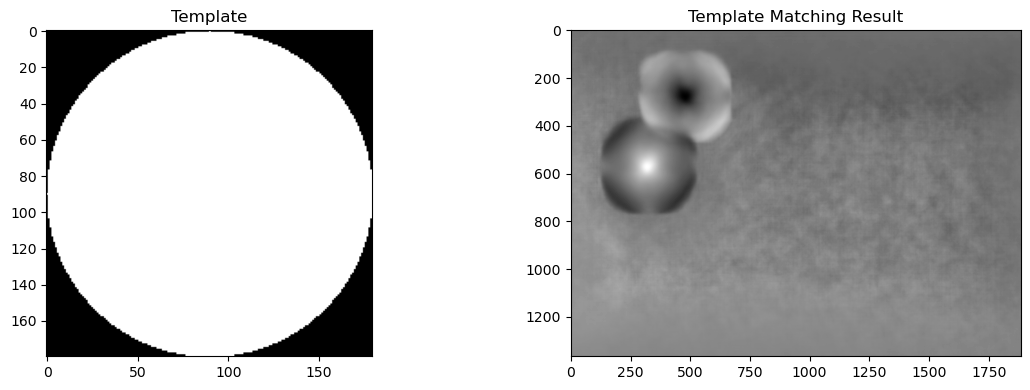

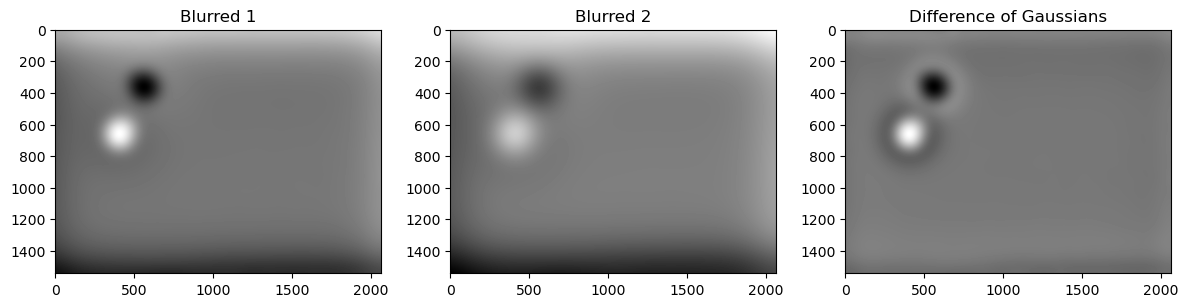

In [22]:
# Assuming you have your unwrapped_phase image stored in a variable named unwrapped_phase

x_peak, y_peak, template, result = find_cell(image_data[0]['back_subs_unwrapped_phase'])

# Plot the template
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(template, cmap='gray')
plt.title('Template')

# Plot the result of template matching
plt.subplot(1, 2, 2)
plt.imshow(result, cmap='gray')
plt.title('Template Matching Result')

plt.tight_layout()
plt.show()

x_peak, y_peak, blurred1, blurred2, dog = find_cell_DoG(image_data[0]['back_subs_unwrapped_phase'])

# Plot the images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(blurred1, cmap='gray')
plt.title('Blurred 1')

plt.subplot(1, 3, 2)
plt.imshow(blurred2, cmap='gray')
plt.title('Blurred 2')

plt.subplot(1, 3, 3)
plt.imshow(dog, cmap='gray')
plt.title('Difference of Gaussians')

plt.tight_layout()
plt.show()

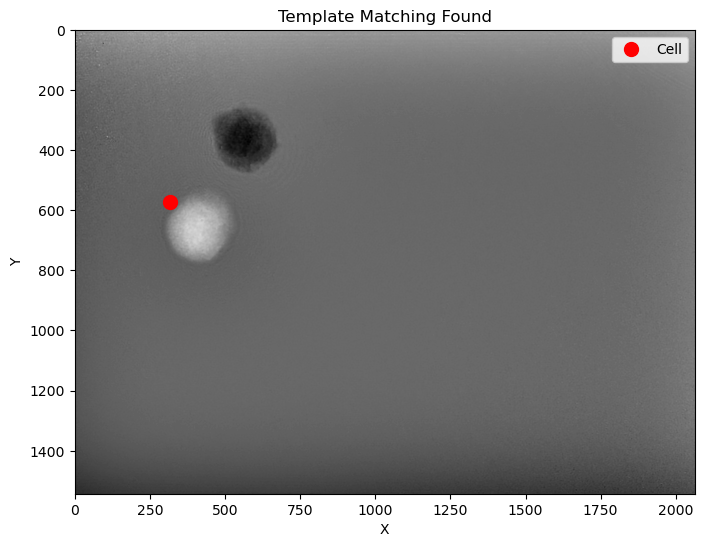

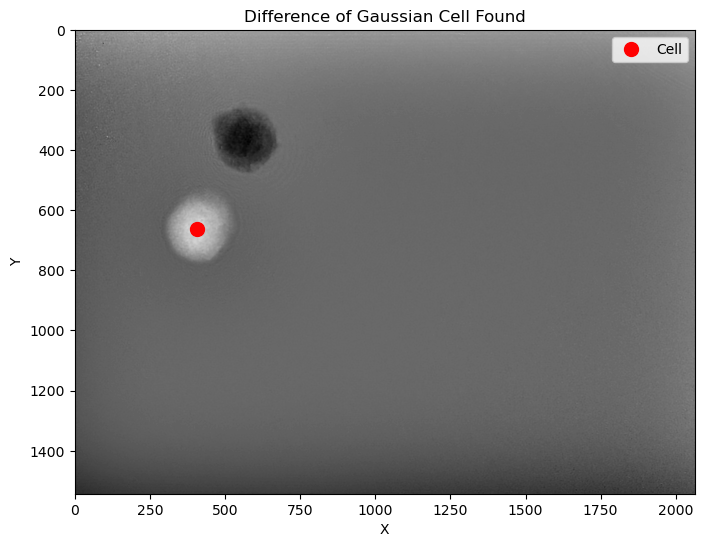

In [23]:
# Get the unwrapped phase image of the first data entry
unwrapped_phase = image_data[0]['back_subs_unwrapped_phase']

# Find the cell in the unwrapped phase image
cell_x, cell_y,template, result = find_cell(unwrapped_phase)
cell_x_DoG, cell_y_DoG, blurred1, blurred2, dog  = find_cell_DoG(unwrapped_phase)

# Plot the cell with Template Matching
plt.figure(figsize=(8, 8))
plt.imshow(unwrapped_phase, cmap='gray')
plt.plot(cell_x, cell_y, 'ro', markersize=10, label='Cell')
plt.title('Template Matching Found')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

# Plot the cell with Difference of Gaussian
plt.figure(figsize=(8, 8))
plt.imshow(unwrapped_phase, cmap='gray')
plt.plot(cell_x_DoG, cell_y_DoG, 'ro', markersize=10, label='Cell')
plt.title('Difference of Gaussian Cell Found')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()



In [24]:
crop_size = 512  # in PIXELS, adjust value as desired. Default = 500

# Loop through image data to process each image

for data in image_data:
    
    # Extract the unwrapped phase and other necessary data for the current image
    unwrapped_phase = data['back_subs_unwrapped_phase']
    amplitude = data['amplitude']
    fluorescence_image = data['fluorescence_image']
    u_cell = data['u_cell']
    u_background = data['u_background']
    holo = data['hologram_image']
    holo_background = data['background_image']

    # Perform cell detection to get the center location
    #center_x, center_y,template, result = find_cell(unwrapped_phase) # much faster, but the center of the cell is not as accurate
    center_x, center_y, blurred1, blurred2, dog = find_cell_DoG(unwrapped_phase)
    
    #MANUALLY input the bead location
    # FOR 20240429_beads_500_nm_1_HOLO
    #center_x = 784-1
    #center_y = 1228-1
    
    # FOR center FOV
    #center_x = 1032-1
    #center_y = 772-1
       
    # FOR generic cell! EDIT accordingly
    #center_x = center_x_input-1
    #center_y = center_y_input-1
       
    # Centering in case cells are near the border
    half_image_target = crop_size // 2
    if center_x < half_image_target:
        center_x = half_image_target + 1
        print('Cell out of bounds. center_x < half_image_target')

    if center_y < half_image_target:
        center_y = half_image_target + 1
        print('Cell out of bounds. center_y < half_image_target')

    if center_x > unwrapped_phase.shape[1] - half_image_target:
        center_x = center_x - half_image_target - 1
        print('Cell out of bounds. center_x > phase_x_col - half_image_target')

    if center_y > unwrapped_phase.shape[0] - half_image_target:
        center_y = center_y - half_image_target - 1
        print('Cell out of bounds. center_y > phase_y_row - half_image_target')
    
    # Calculate the boundaries for cropping
    x_start = max(0, center_x - crop_size // 2)
    x_end = min(unwrapped_phase.shape[1], center_x + crop_size // 2)
    y_start = max(0, center_y - crop_size // 2)
    y_end = min(unwrapped_phase.shape[0], center_y + crop_size // 2)

    # Crop the unwrapped phase, amplitude, and fluorescence image
    cropped_unwrapped_phase = unwrapped_phase[y_start:y_end, x_start:x_end]
    cropped_amplitude = amplitude[y_start:y_end, x_start:x_end]
    cropped_fluorescence_image = fluorescence_image[y_start:y_end, x_start:x_end]
    cropped_u_cell = u_cell[y_start:y_end, x_start:x_end]
    cropped_u_background = u_background[y_start:y_end, x_start:x_end]
    cropped_holo = holo[y_start:y_end, x_start:x_end]
    cropped_holo_background = holo_background[y_start:y_end, x_start:x_end]

    # Store the cropped images in the image data dictionary
    data['cropped_unwrapped_phase'] = cropped_unwrapped_phase
    data['cropped_amplitude'] = cropped_amplitude
    data['cropped_fluorescence_image'] = cropped_fluorescence_image
    data['cropped_u_cell'] = cropped_u_cell
    data['cropped_u_background'] = cropped_u_background
    data['cropped_holo'] = cropped_holo
    data['cropped_holo_background'] = cropped_holo_background

Cell out of bounds. center_x < half_image_target
Cell out of bounds. center_x < half_image_target
Cell out of bounds. center_y < half_image_target
Cell out of bounds. center_x > phase_x_col - half_image_target
Cell out of bounds. center_x < half_image_target
Cell out of bounds. center_y < half_image_target
Cell out of bounds. center_x > phase_x_col - half_image_target
Cell out of bounds. center_x < half_image_target
Cell out of bounds. center_y < half_image_target
Cell out of bounds. center_x < half_image_target
Cell out of bounds. center_y < half_image_target
Cell out of bounds. center_y < half_image_target
Cell out of bounds. center_y < half_image_target
Cell out of bounds. center_x > phase_x_col - half_image_target
Cell out of bounds. center_x > phase_x_col - half_image_target
Cell out of bounds. center_y > phase_y_row - half_image_target
Cell out of bounds. center_x > phase_x_col - half_image_target
Cell out of bounds. center_y > phase_y_row - half_image_target
Cell out of bounds. 

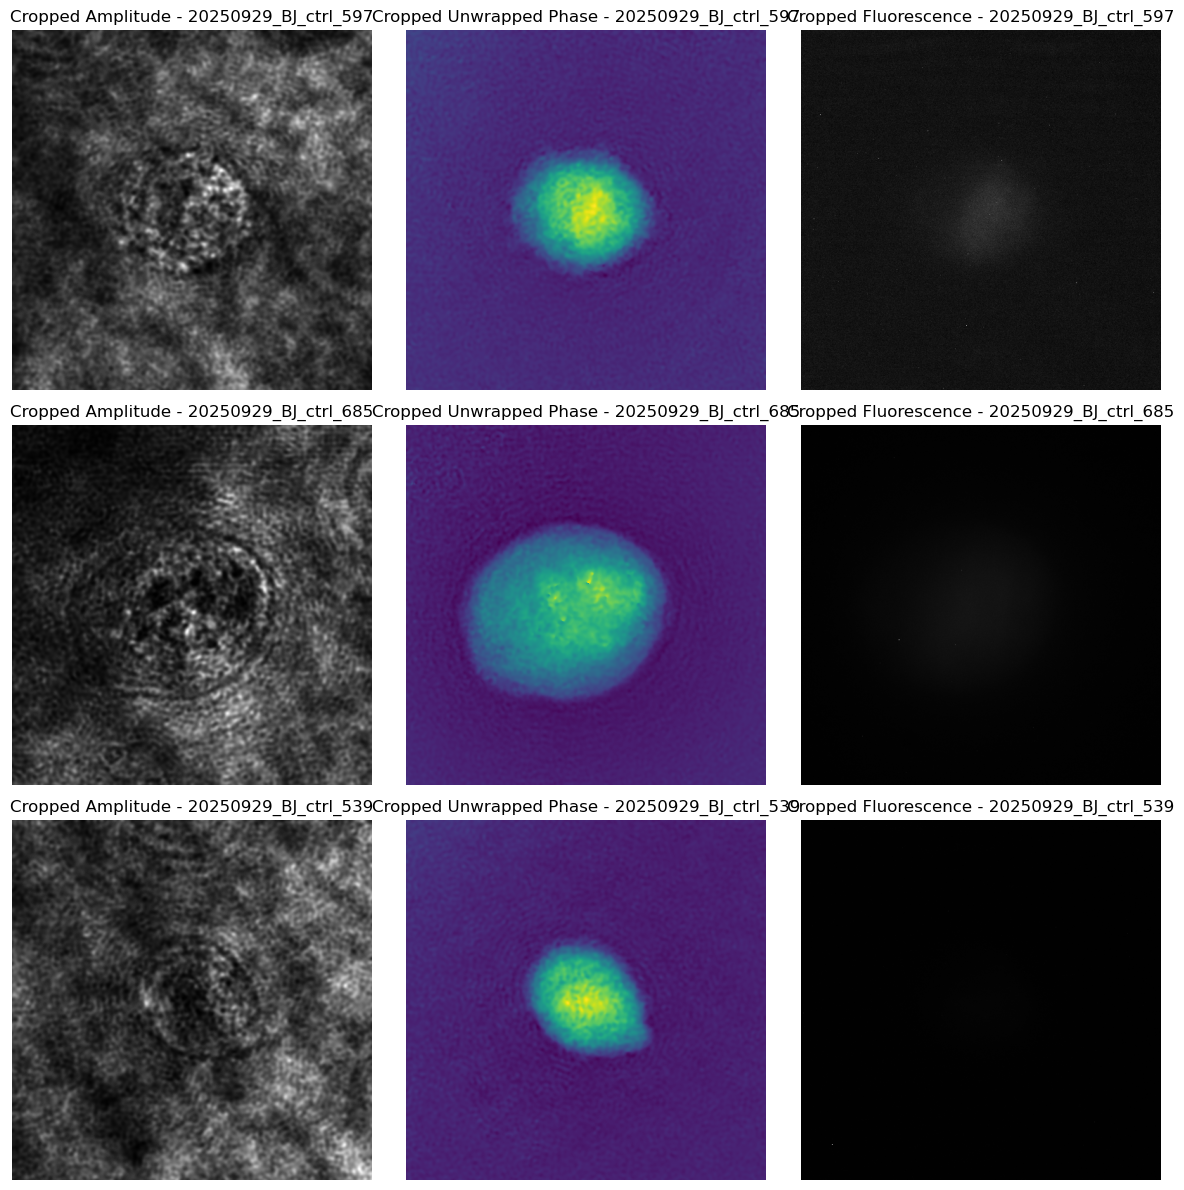

In [25]:
def plot_cropped_images(image_data, random_indices):
    num_images = len(random_indices)
    fig, axes = plt.subplots(num_images, 3, figsize=(12, num_images * 4), dpi=fig_dpi)

    for i, idx in enumerate(random_indices):
        try:
            # Extract cropped images for the current image
            cropped_amplitude = image_data[idx]['cropped_amplitude']
            cropped_unwrapped_phase = image_data[idx]['cropped_unwrapped_phase']
            cropped_fluorescence_image = image_data[idx]['cropped_fluorescence_image']

            # Plot cropped amplitude
            axes[i, 0].imshow(cropped_amplitude, cmap='gray')
            axes[i, 0].set_title(f'Cropped Amplitude - {image_data[idx]["image_of_interest"]}')
            axes[i, 0].axis('off')

            # Plot cropped unwrapped phase
            axes[i, 1].imshow(cropped_unwrapped_phase, cmap='viridis')
            axes[i, 1].set_title(f'Cropped Unwrapped Phase - {image_data[idx]["image_of_interest"]}')
            axes[i, 1].axis('off')

            # Plot cropped fluorescence image
            axes[i, 2].imshow(cropped_fluorescence_image, cmap='gray')
            axes[i, 2].set_title(f'Cropped Fluorescence - {image_data[idx]["image_of_interest"]}')
            axes[i, 2].axis('off')
            
        except KeyError:
            print(f"Cropped images not found for image {image_data[idx]['image_of_interest']}. Skipping...")

    plt.tight_layout()
    plt.show()

# Plot the cropped amplitude, unwrapped phase, and fluorescence images for the randomly selected images
plot_cropped_images(image_data, random_indices)

Reults:
Total cells = 25
Template matching:
    Correctly cropped = 20
    Correctly centered = 1
DoG:
    Correctly cropped = 16
    Correctly centered = 15

## BPM

# .hdf5 file saving after complex-amplitude field reconstruction (plus hase unwrapping , and background substraction and cell localization, cropping)

In [ ]:
# Define the directory to save the processed files
processed_dir = os.path.join(base_directory, "processed_holo_qpi_fluor")
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)

# Loop through image data to save arrays to HDF5 files and TIFF file
#for data in [image_data[0]]: # For single bead
for data in image_data: # For multiple cells/beads
    image_of_interest = data['image_of_interest']
    file_path = os.path.join(processed_dir, f"{image_of_interest}.hdf5")
    tiff_file_path = os.path.join(processed_dir, f"{image_of_interest}.tiff")

    # Check if the file already exists
    if os.path.exists(file_path):
        print("File already exists:", file_path)
        continue  # Skip saving if the file exists

    # Extract the necessary arrays
    
    cropped_holo = data['cropped_holo'] 
    cropped_holo_background = data['cropped_holo_background']
    u_cell = data['u_cell']
    u_background = data['u_background']
    cropped_unwrapped_phase_image = data['cropped_unwrapped_phase']  # Assuming this key exists
    cropped_amplitude = data['cropped_amplitude']
    cropped_fluorescence_array = data['cropped_fluorescence_image']  # Assuming this key exists
    cropped_u_cell = data['cropped_u_cell']
    cropped_u_background = data['cropped_u_background']
    
    # Create a new .hdf5 file
    with h5py.File(file_path, "w") as f:
        # Save the arrays to the file
        #f.create_dataset("u_cell", data=u_cell)
        #f.create_dataset("u_background", data=u_background)
        
        f.create_dataset("crop_holo", data=cropped_holo)
        f.create_dataset("crop_holo_background", data=cropped_holo_background)
        
        f.create_dataset("crop_u_cell", data=cropped_u_cell)
        f.create_dataset("crop_u_background", data=cropped_u_background)
        f.create_dataset("phase_image", data=cropped_unwrapped_phase_image)
        f.create_dataset("amplitude", data=cropped_amplitude)
        f.create_dataset("fluorescence", data=cropped_fluorescence_array)
        
    # Stack phase image and amplitude arrays
    phase_amplitude_stack = np.stack((cropped_unwrapped_phase_image, cropped_amplitude,cropped_fluorescence_array), axis = 0)
    # cropped @ 256
    #phase_amplitude_stack = np.stack((phase_image_256, bpm_phase, amplitude_image_256, bpm_amplitude), axis = 0)
    # Save TIFF file with two channels (phase image and amplitude) in 16-bit format
    iio.imwrite(tiff_file_path, phase_amplitude_stack)

    print("Data from complex-amplitude field reconstruction saved to", file_path)
    print("TIFF file saved to", tiff_file_path)

Data from complex-amplitude field reconstruction saved to /home/jvasquez/updepla/users/jvasquez/DATA_raw_QPI/20250929_BJ_ctrl/processed_holo_qpi_fluor/20250929_BJ_ctrl_203.hdf5
TIFF file saved to /home/jvasquez/updepla/users/jvasquez/DATA_raw_QPI/20250929_BJ_ctrl/processed_holo_qpi_fluor/20250929_BJ_ctrl_203.tiff
Data from complex-amplitude field reconstruction saved to /home/jvasquez/updepla/users/jvasquez/DATA_raw_QPI/20250929_BJ_ctrl/processed_holo_qpi_fluor/20250929_BJ_ctrl_204.hdf5
TIFF file saved to /home/jvasquez/updepla/users/jvasquez/DATA_raw_QPI/20250929_BJ_ctrl/processed_holo_qpi_fluor/20250929_BJ_ctrl_204.tiff
Data from complex-amplitude field reconstruction saved to /home/jvasquez/updepla/users/jvasquez/DATA_raw_QPI/20250929_BJ_ctrl/processed_holo_qpi_fluor/20250929_BJ_ctrl_227.hdf5
TIFF file saved to /home/jvasquez/updepla/users/jvasquez/DATA_raw_QPI/20250929_BJ_ctrl/processed_holo_qpi_fluor/20250929_BJ_ctrl_227.tiff
Data from complex-amplitude field reconstruction saved 